In [1]:
!pip install -U adapter-transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import re
import torch
from transformers import BertTokenizer, get_linear_schedule_with_warmup, BertForSequenceClassification, BertConfig
from transformers import BertTokenizer, BertConfig, BertModelWithHeads
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
import time
import datetime
import random
import datasets
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Data Preparing

dataset = load_dataset("humarin/chatgpt-paraphrases")

# 將資料分成0和1
category={}
# for i in range(len(data)):
for i in range(0, 20000):
#     chatgpt=data.iloc[i]["paraphrases"][:].split(', ')
#     for j in chatgpt:
#         category[j[1:-1]]='chatgpt'
    category[dataset['train'][i]["paraphrases"][:].split(', ')[0][2:-1]]=1
    category[dataset['train'][i]['text']]=0
    # category[dataset.iloc(i)["paraphrases"][:].split(', ')[0][2:-1]]=1
    # category[dataset.iloc(i)['text']]=0

data=pd.DataFrame(category.items(),columns=["text","label"])
data=data.sample(frac=1)

print(data["label"].value_counts())


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

0    19998
1    19757
Name: label, dtype: int64


In [5]:
def get_label_string_len(data):
  len0=0
  len1=0
  for i in range(0, data.shape[0]):
    if data["label"].values[i]==0:
      len0 += len(data["text"].values[i])
    else:
      len1 += len(data["text"].values[i])

  print(len0/data["label"].value_counts()[0])
  print(len1/data["label"].value_counts()[1])

In [6]:
# print(data.head(n=30).to_string(index=False))
# len0=0
# len1=0
# for i in range(0, data.shape[0]):
#   if data["label"].values[i]==0:
#     len0 += len(data["text"].values[i])
#   else:
#     len1 += len(data["text"].values[i])

# print(len0/data["label"].value_counts()[0])
# print(len1/data["label"].value_counts()[1])
get_label_string_len(data)

59.67056705670567
65.60479829933695


In [7]:
# train_size = int(0.9 * len(data))
# val_size = len(data) - train_size


train_df, validation_df = train_test_split(data, random_state=777, test_size=0.1)
get_label_string_len(train_df)
get_label_string_len(validation_df)

train_dataset = Dataset.from_dict(train_df)
validation_dataset = Dataset.from_dict(validation_df)
dataset = datasets.DatasetDict({"train":train_dataset,"validation":validation_dataset})
# print(dataset)

59.689568984670075
65.71431786216597
59.49899699097292
64.6226034308779


In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

def encode_batch(batch):
  """Encodes a batch of input data using the model tokenizer."""
  return tokenizer(batch["text"], max_length=80, truncation=True, padding="max_length")

# Encode the input data
dataset = dataset.map(encode_batch, batched=True)
# The transformers model expects the target class column to be named "labels"
dataset = dataset.rename_column("label", "labels")
# Transform to pytorch tensors and only output the required columns
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/35779 [00:00<?, ? examples/s]

Map:   0%|          | 0/3976 [00:00<?, ? examples/s]

In [10]:
# train
config = BertConfig.from_pretrained(
    "bert-base-cased",
    num_labels=2,
)
model = BertModelWithHeads.from_pretrained(
    "bert-base-cased",
    config=config,
)

/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/bert/adapter_model.py:269: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/adapters/models/bert/adapter_model.py:247: FutureWarning: This class has been renamed to `BertAdapterModel` in v3. Please use the new class instead as this class might be removed in a future version.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModelWithHeads: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModelWithHeads from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModelWithHeads from the checkpoint of a mod

Every dataset sample has an input text and a binary label:

In [11]:
# Add a new adapter
model.add_adapter("rotten_tomatoes")
# Add a matching classification head
model.add_classification_head(
    "rotten_tomatoes",
    num_labels=2
  )
# Activate the adapter
model.train_adapter("rotten_tomatoes")

model.cuda()

BertModelWithHeads(
  (shared_parameters): ModuleDict()
  (bert): BertModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict()
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (key): Linear(
                in_features=768, out_features=768, bias=True
                (loras): ModuleDict()
              )
              (value): Linear(
                in_features=768, out_fea

In [12]:
import numpy as np
from transformers import TrainingArguments, AdapterTrainer, EvalPrediction

training_args = TrainingArguments(
    learning_rate=1e-4,
    num_train_epochs=6,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    logging_steps=200,
    output_dir="./drive/MyDrive/model/Bert/output",
    overwrite_output_dir=True,
    # The next line is important to ensure the dataset labels are properly passed to the model
    remove_unused_columns=False,
)

def compute_accuracy(p: EvalPrediction):
  preds = np.argmax(p.predictions, axis=1)
  return {"acc": (preds == p.label_ids).mean()}

trainer = AdapterTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_accuracy,
)

Start the training 🚀

In [13]:
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 35779
  Num Epochs = 6
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 6714
  Number of trainable parameters = 1486658


Step,Training Loss
200,0.508700
400,0.366600
600,0.335200
800,0.315500
1000,0.306300
1200,0.297200
1400,0.268300
1600,0.280700
1800,0.264600
2000,0.261200


Saving model checkpoint to ./drive/MyDrive/model/Bert/output/checkpoint-500
Configuration saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/adapter_config.json
Module weights saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/pytorch_model_head.bin
Configuration saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/head_config.json
Module weights saved in ./drive/MyDrive/model/Bert/output/checkpoint-500/rotten_tomatoes/pytorch_model_head.bin
Saving model checkpoint to ./drive/MyDrive/model/Bert/output/checkpoint-1000
Configuration saved in ./drive/MyDrive/model/Bert/output/checkpoint-1000/rotten_tomatoes/adapter_config.json
Module weights saved in ./drive/MyDrive/model/Bert/output/checkpoint-1000/rotten_tomato

TrainOutput(global_step=6714, training_loss=0.2470947355964122, metrics={'train_runtime': 1773.8505, 'train_samples_per_second': 121.021, 'train_steps_per_second': 3.785, 'total_flos': 8978516789040000.0, 'train_loss': 0.2470947355964122, 'epoch': 6.0})

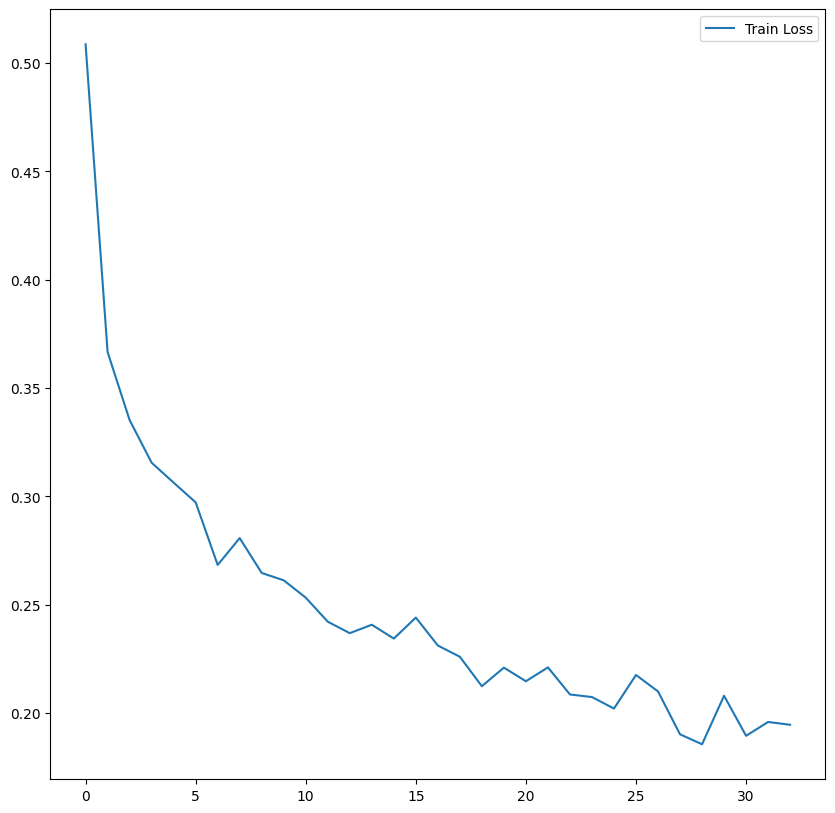

In [14]:
import matplotlib.pyplot as plt
losses = trainer.state.log_history
x = list(range(0, len(losses)-1))
plt_train_loss = []


for loss in losses:
  if 'loss' in loss:
    plt_train_loss.append(loss['loss'])


fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(x, plt_train_loss)
ax.legend(['Train Loss'])

Looks good! Let's evaluate our adapter on the validation split of the dataset to see how well it learned:

In [15]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 3976
  Batch size = 32


{'eval_loss': 0.25300708413124084,
 'eval_acc': 0.9014084507042254,
 'eval_runtime': 16.5014,
 'eval_samples_per_second': 240.95,
 'eval_steps_per_second': 7.575,
 'epoch': 6.0}

We can put our trained model into a `transformers` pipeline to be able to make new predictions conveniently:

In [16]:
losses = trainer.state.log_history
x = list(range(0, len(losses)-2))
plt_validation_loss = []


for loss in losses:
  print(loss)
#   if 'loss' in loss:
#     plt_validation_loss.append(loss['loss'])


# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(x, plt_train_loss)
# ax.legend(['validation Loss'])

{'loss': 0.5087, 'learning_rate': 9.702114983616324e-05, 'epoch': 0.18, 'step': 200}
{'loss': 0.3666, 'learning_rate': 9.404229967232648e-05, 'epoch': 0.36, 'step': 400}
{'loss': 0.3352, 'learning_rate': 9.106344950848973e-05, 'epoch': 0.54, 'step': 600}
{'loss': 0.3155, 'learning_rate': 8.808459934465296e-05, 'epoch': 0.71, 'step': 800}
{'loss': 0.3063, 'learning_rate': 8.510574918081621e-05, 'epoch': 0.89, 'step': 1000}
{'loss': 0.2972, 'learning_rate': 8.212689901697945e-05, 'epoch': 1.07, 'step': 1200}
{'loss': 0.2683, 'learning_rate': 7.914804885314269e-05, 'epoch': 1.25, 'step': 1400}
{'loss': 0.2807, 'learning_rate': 7.616919868930593e-05, 'epoch': 1.43, 'step': 1600}
{'loss': 0.2646, 'learning_rate': 7.319034852546918e-05, 'epoch': 1.61, 'step': 1800}
{'loss': 0.2612, 'learning_rate': 7.021149836163241e-05, 'epoch': 1.79, 'step': 2000}
{'loss': 0.2532, 'learning_rate': 6.723264819779566e-05, 'epoch': 1.97, 'step': 2200}
{'loss': 0.2421, 'learning_rate': 6.425379803395888e-05, '

In [ ]:
# from sklearn.metrics import confusion_matrix
# y_pred =etc.predict(X_test_tfidf)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)

# import seaborn as sn
# import matplotlib.pyplot as plt
# confusion_matrix = pd.DataFrame(cm, index = [i for i in ["ChatGPT","Human"]],
#                   columns = [i for i in ["ChatGPT","Human"]])
# plt.figure(figsize = (20,14))
# sn.heatmap(confution_matrix, annot=True,cmap="YlGnBu", fmt='g')

In [17]:
from transformers import TextClassificationPipeline

classifier = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=training_args.device.index)
# BertAdapterModel
classifier("How do individuals combat global warming and promote sustainability?")

The model 'BertModelWithHeads' is not supported for . Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BloomForSequenceClassification', 'CamembertForSequenceClassification', 'CanineForSequenceClassification', 'ConvBertForSequenceClassification', 'CTRLForSequenceClassification', 'Data2VecTextForSequenceClassification', 'DebertaForSequenceClassification', 'DebertaV2ForSequenceClassification', 'DistilBertForSequenceClassification', 'ElectraForSequenceClassification', 'ErnieForSequenceClassification', 'EsmForSequenceClassification', 'FlaubertForSequenceClassification', 'FNetForSequenceClassification', 'FunnelForSequenceClassification', 'GPT2ForSequenceClassification', 'GPT2ForSequenceClassification', 'GPTNeoForSequenceClassification', 'GPTJForSequenceClassification', 'IBertForSequenceClassification', 'LayoutLMForSequenceClassification', '

[{'label': 'LABEL_1', 'score': 0.8079118728637695}]

At last, we can also extract the adapter from our model and separately save it for later reuse. Note the size difference compared to a full model!

In [18]:
model.save_adapter("./drive/MyDrive/model/Bert", "rotten_tomatoes")

# !ls -lh final_adapter

Configuration saved in ./drive/MyDrive/model/Bert/adapter_config.json
Module weights saved in ./drive/MyDrive/model/Bert/pytorch_adapter.bin
Configuration saved in ./drive/MyDrive/model/Bert/head_config.json
Module weights saved in ./drive/MyDrive/model/Bert/pytorch_model_head.bin


ls: cannot access 'final_adapter': No such file or directory


**Share your work!**

The next step after training is to share our adapter with the world via _AdapterHub_. [Read our guide](https://docs.adapterhub.ml/contributing.html) on how to prepare the adapter module we just saved and contribute it to the Hub!

➡️ Also continue with [the next Colab notebook](https://colab.research.google.com/github/Adapter-Hub/adapter-transformers/blob/master/notebooks/02_Adapter_Inference.ipynb) to learn how to use adapters from the Hub.